# **ML Model: Predicting Trade Sensitivity to Tariff Shocks**

This notebook builds a supervised machine learning model on top of the
final `ranking` table (saved as `ranking_final.parquet`), in order to
classify trade flows as **sensitive** or **resilient** to tariff shocks.

- Input: `ranking_final.parquet` (from the main analysis notebook)
- Label: `is_sensitive` (derived from `SensitivityScore`, top 25% = 1)
- Algorithms: Logistic Regression (baseline), tree-based models later


## **1. Setting up the Environment + Spark + Drive mount**

In [ ]:
!pip install -q pyspark==3.5.1

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("TariffSensitivity_ML")
    .getOrCreate()
)

print("Spark Session Created")
print("Spark Version:", spark.version)

from google.colab import drive
drive.mount('/content/drive')
print("Google Drive Mounted")

Spark Session Created
Spark Version: 3.5.1
Mounted at /content/drive
Google Drive Mounted


## **2. Load the Dataset `(ranking_final.parquet)`**

In [ ]:
from pyspark.sql import functions as F

input_path = "/content/drive/MyDrive/bigdata/ranking_final.parquet"

ranking = spark.read.parquet(input_path)

print("Loaded ranking DataFrame from:", input_path)
print("Row count:", ranking.count())
ranking.printSchema()

Loaded ranking DataFrame from: /content/drive/MyDrive/bigdata/ranking_final.parquet
Row count: 15862
root
 |-- ProductCode: string (nullable = true)
 |-- ReporterName: string (nullable = true)
 |-- PartnerName: string (nullable = true)
 |-- ShockEventCount: long (nullable = true)
 |-- AvgTradeChange_ShockYears: double (nullable = true)
 |-- MedianTradeChange_ShockYears: double (nullable = true)
 |-- Corr_Trade_Tariff: double (nullable = true)
 |-- Score_MedianDrop: double (nullable = true)
 |-- Score_Corr: double (nullable = true)
 |-- Score_ShockCount: double (nullable = true)
 |-- SensitivityScore: double (nullable = true)



#### **Quick sanity check of data**

In [ ]:
ranking.select(
    "ProductCode", "ReporterName", "PartnerName",
    "ShockEventCount",
    "MedianTradeChange_ShockYears",
    "Corr_Trade_Tariff",
    "Score_MedianDrop", "Score_Corr", "Score_ShockCount",
    "SensitivityScore"
).show(10, truncate=False)

+-----------+------------+------------------+---------------+----------------------------+-------------------+-----------------+------------------+----------------+------------------+
|ProductCode|ReporterName|PartnerName       |ShockEventCount|MedianTradeChange_ShockYears|Corr_Trade_Tariff  |Score_MedianDrop |Score_Corr        |Score_ShockCount|SensitivityScore  |
+-----------+------------+------------------+---------------+----------------------------+-------------------+-----------------+------------------+----------------+------------------+
|2903       |China       |Singapore         |3              |-99.78881674336506          |-0.9999996289356987|99.78881674336506|0.9999996289356987|3.0             |151.28879819015   |
|7208       |China       |Russian Federation|3              |-99.88360540697416          |-0.9971911773135235|99.88360540697416|0.9971911773135235|3.0             |151.24316427265032|
|8450       |Brazil      |Netherlands       |3              |-99.6974341246312  

## **3. Create the binary label `is_sensitive`**

In [ ]:
# Compute 75th percentile of SensitivityScore
quantiles = ranking.approxQuantile("SensitivityScore", [0.75], 0.001)
sensitivity_threshold = quantiles[0]

print("SensitivityScore 75th percentile threshold:", sensitivity_threshold)

# Add binary label: 1 = sensitive (>= threshold), 0 = resilient (< threshold)
ranking_labeled = ranking.withColumn(
    "is_sensitive",
    F.when(F.col("SensitivityScore") >= F.lit(sensitivity_threshold), F.lit(1)).otherwise(F.lit(0))
)

# Check class balance
ranking_labeled.groupBy("is_sensitive").count().show()

SensitivityScore 75th percentile threshold: 74.80295749764852
+------------+-----+
|is_sensitive|count|
+------------+-----+
|           1| 3978|
|           0|11884|
+------------+-----+



#### **Peek at a few labeled rows**

In [ ]:
ranking_labeled.select(
    "ProductCode", "ReporterName", "PartnerName",
    "SensitivityScore", "is_sensitive"
).orderBy(F.col("SensitivityScore").desc()).show(10, truncate=False)

+-----------+------------+------------------+------------------+------------+
|ProductCode|ReporterName|PartnerName       |SensitivityScore  |is_sensitive|
+-----------+------------+------------------+------------------+------------+
|2903       |China       |Singapore         |151.28879819015   |1           |
|7208       |China       |Russian Federation|151.24316427265032|1           |
|8450       |Brazil      |Netherlands       |151.13980647973506|1           |
|2809       |India       |Saudi Arabia      |150.99879623845953|1           |
|4005       |South Africa|Canada            |150.99879518072294|1           |
|2926       |India       |Indonesia         |150.99623349036355|1           |
|2001       |Canada      |Chile             |150.9952038996656 |1           |
|2809       |India       |Philippines       |150.99410042082152|1           |
|2610       |India       |United States     |150.99118942731275|1           |
|7206       |India       |Singapore         |150.98784504031778|

## **3. Define features + ML pipeline**

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Numeric features (all derived from behavior, not from the label itself)
numeric_features = [
    "ShockEventCount",
    "MedianTradeChange_ShockYears",
    "Corr_Trade_Tariff",
    "Score_MedianDrop",
    "Score_Corr",
    "Score_ShockCount"
]

# Categorical features
categorical_features = [
    "ProductCode",
    "ReporterName",
    "PartnerName"
]

# 1. StringIndexers for categoricals
indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=col + "_idx",
        handleInvalid="keep"
    )
    for col in categorical_features
]

# 2. OneHotEncoder for indexed categoricals
encoder = OneHotEncoder(
    inputCols=[col + "_idx" for col in categorical_features],
    outputCols=[col + "_ohe" for col in categorical_features],
    handleInvalid="keep"
)

# 3. Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=numeric_features + [col + "_ohe" for col in categorical_features],
    outputCol="features"
)

## **4. Training a Logistic Regression model**

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Train–test split
train_df, test_df = ranking_labeled.randomSplit([0.8, 0.2], seed=42)

# Classifier
lr = LogisticRegression(
    labelCol="is_sensitive",
    featuresCol="features",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0  # L2 regularization
)

# Full pipeline: indexers -> encoder -> assembler -> classifier
lr_pipeline = Pipeline(stages=indexers + [encoder, assembler, lr])

# Fit model
lr_model = lr_pipeline.fit(train_df)

# Predict on test set
lr_predictions = lr_model.transform(test_df)

lr_predictions.select(
    "ProductCode", "ReporterName", "PartnerName",
    "is_sensitive", "probability", "prediction"
).show(10, truncate=False)

+-----------+------------+--------------+------------+----------------------------------------+----------+
|ProductCode|ReporterName|PartnerName   |is_sensitive|probability                             |prediction|
+-----------+------------+--------------+------------+----------------------------------------+----------+
|1001       |Canada      |China         |1           |[0.0730208739736196,0.9269791260263804] |1.0       |
|1001       |Canada      |Mexico        |1           |[0.24252265933258013,0.7574773406674199]|1.0       |
|1005       |Brazil      |Argentina     |0           |[0.9840511322961507,0.01594886770384929]|0.0       |
|1008       |Brazil      |Argentina     |0           |[0.7374852952268954,0.26251470477310457]|0.0       |
|1102       |Canada      |Netherlands   |1           |[0.5276644503677648,0.47233554963223523]|0.0       |
|1102       |Canada      |Spain         |1           |[0.3826376152861782,0.6173623847138219] |1.0       |
|1102       |China       |United King

## **5. Evaluate the model (AUC + accuracy)**

In [ ]:
# AUC (ranking quality)
auc_eval = BinaryClassificationEvaluator(
    labelCol="is_sensitive",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = auc_eval.evaluate(lr_predictions)
print("Logistic Regression - Test AUC:", auc)

# Accuracy
acc_eval = MulticlassClassificationEvaluator(
    labelCol="is_sensitive",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = acc_eval.evaluate(lr_predictions)
print("Logistic Regression - Test Accuracy:", accuracy)

# Confusion-style counts
lr_predictions.groupBy("is_sensitive", "prediction").count().orderBy("is_sensitive", "prediction").show()

Logistic Regression - Test AUC: 0.9932205595315547
Logistic Regression - Test Accuracy: 0.9357945425361156
+------------+----------+-----+
|is_sensitive|prediction|count|
+------------+----------+-----+
|           0|       0.0| 2311|
|           0|       1.0|    9|
|           1|       0.0|  191|
|           1|       1.0|  604|
+------------+----------+-----+



## **Plots**

In [ ]:
lr_predictions.printSchema()


root
 |-- ProductCode: string (nullable = true)
 |-- ReporterName: string (nullable = true)
 |-- PartnerName: string (nullable = true)
 |-- ShockEventCount: long (nullable = true)
 |-- AvgTradeChange_ShockYears: double (nullable = true)
 |-- MedianTradeChange_ShockYears: double (nullable = true)
 |-- Corr_Trade_Tariff: double (nullable = true)
 |-- Score_MedianDrop: double (nullable = true)
 |-- Score_Corr: double (nullable = true)
 |-- Score_ShockCount: double (nullable = true)
 |-- SensitivityScore: double (nullable = true)
 |-- is_sensitive: integer (nullable = false)
 |-- ProductCode_idx: double (nullable = false)
 |-- ReporterName_idx: double (nullable = false)
 |-- PartnerName_idx: double (nullable = false)
 |-- ProductCode_ohe: vector (nullable = true)
 |-- ReporterName_ohe: vector (nullable = true)
 |-- PartnerName_ohe: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- pr

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Extract probability of class 1 (sensitive) from the vector column
lr_probs = lr_predictions.select(
    col("is_sensitive").cast("int").alias("label"),
    vector_to_array(col("probability"))[1].alias("prob1")   # second element = P(class 1)
)

# Convert to Pandas for sklearn plotting
lr_pdf = lr_probs.toPandas()
lr_pdf.head()


,label,prob1
0,1,0.926979
1,1,0.757477
2,0,0.015949
3,0,0.262515
4,1,0.472336


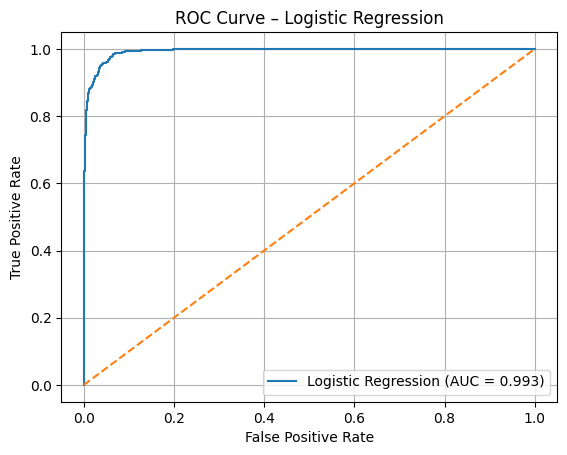

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(lr_pdf["label"], lr_pdf["prob1"])
roc_auc = roc_auc_score(lr_pdf["label"], lr_pdf["prob1"])

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

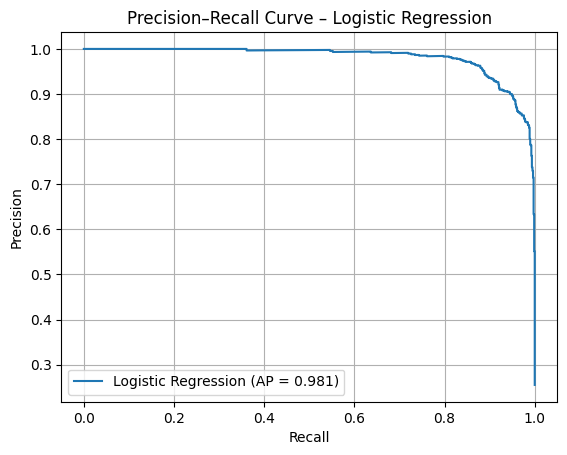

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(lr_pdf["label"], lr_pdf["prob1"])
ap = average_precision_score(lr_pdf["label"], lr_pdf["prob1"])

plt.figure()
plt.plot(recall, precision, label=f"Logistic Regression (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()